<Axes: title={'center': '테스트'}>

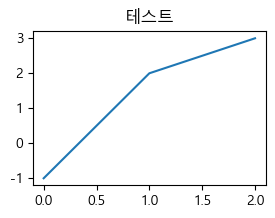

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ---------------------------------------
# 한글 폰트 설정
# ---------------------------------------

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

pd.Series([-1,2,3]).plot(title='테스트', figsize=(3,2))

#### 데이터 준비

In [3]:
# --------------------
# 데이터 프레임 생성
# --------------------

df1 = pd.read_csv('data/따릉이대여량예측/시간대별기상정보.csv',
                  parse_dates=True, index_col='일시').iloc[:,3:]
df2 = pd.read_csv('data/따릉이대여량예측/시간대별이용건수.csv',
                  parse_dates=True, index_col='대여일시')

# --------------------
# 데이터 프레임 연결
# --------------------
df = pd.concat([df1, df2], axis=1, join='outer')


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2023-01-01 00:00:00 to 2024-12-31 23:00:00
Freq: h
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   기온(°C)   17542 non-null  float64
 1   강수량(mm)  2043 non-null   float64
 2   풍속(m/s)  17474 non-null  float64
 3   습도(%)    17542 non-null  float64
 4   이용건수     17544 non-null  float64
dtypes: float64(5)
memory usage: 822.4 KB


In [5]:
df.isnull().sum()

기온(°C)         2
강수량(mm)    15501
풍속(m/s)       70
습도(%)          2
이용건수           0
dtype: int64

#### 결측치 처리

In [6]:
# 시계열 보간
df['기온(°C)'] = df['기온(°C)'].interpolate()
df['습도(%)'] = df['습도(%)'].interpolate()
df['기온(°C)'] = df['기온(°C)'].fillna(df['기온(°C)'].mean())
df['습도(%)'] = df['습도(%)'].fillna(df['기온(°C)'].mean())

# 풍속 보간 후 평균 대체
df['풍속(m/s)'] = df['풍속(m/s)'].interpolate()
df['풍속(m/s)'] = df['풍속(m/s)'].fillna(df['풍속(m/s)'].mean())

# 강수량 결측치는 비가 안 온 것으로 가정
df['강수량(mm)'] = df['강수량(mm)'].fillna(0)

#### 파생컬럼 생성

In [7]:
# 시간 기반
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

# 출퇴근/혼잡 시간대
df['is_commute_time'] = df['hour'].isin([7, 8, 9, 17, 18, 19]).astype(int)
df['is_rush_hour'] = df['hour'].isin([6, 7, 8, 9, 17, 18, 19, 20]).astype(int)

# 계절
def get_season(month):
    if month in [3, 4, 5]: return 'spring'
    elif month in [6, 7, 8]: return 'summer'
    elif month in [9, 10, 11]: return 'fall'
    else: return 'winter'
df['season'] = df.index.month.map(get_season)

# 날씨 기반
df['is_rain'] = (df['강수량(mm)'] > 0).astype(int)
df['feels_cold'] = (df['기온(°C)'] < 5).astype(int)
df['feels_hot'] = (df['기온(°C)'] > 30).astype(int)
df['windy'] = (df['풍속(m/s)'] > 7).astype(int)  # 기준은 필요에 따라 조정

# 습도 구간화
def humid_level(h):
    if h < 40: return 'low'
    elif h < 70: return 'normal'
    else: return 'high'
df['humid_level'] = df['습도(%)'].apply(humid_level)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2023-01-01 00:00:00 to 2024-12-31 23:00:00
Freq: h
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   기온(°C)           17544 non-null  float64
 1   강수량(mm)          17544 non-null  float64
 2   풍속(m/s)          17544 non-null  float64
 3   습도(%)            17544 non-null  float64
 4   이용건수             17544 non-null  float64
 5   hour             17544 non-null  int32  
 6   dayofweek        17544 non-null  int32  
 7   is_weekend       17544 non-null  int64  
 8   is_commute_time  17544 non-null  int64  
 9   is_rush_hour     17544 non-null  int64  
 10  season           17544 non-null  object 
 11  is_rain          17544 non-null  int64  
 12  feels_cold       17544 non-null  int64  
 13  feels_hot        17544 non-null  int64  
 14  windy            17544 non-null  int64  
 15  humid_level      17544 non-null  object 
dtypes: float64(5), 

#### 데이터 탐색(EDA)

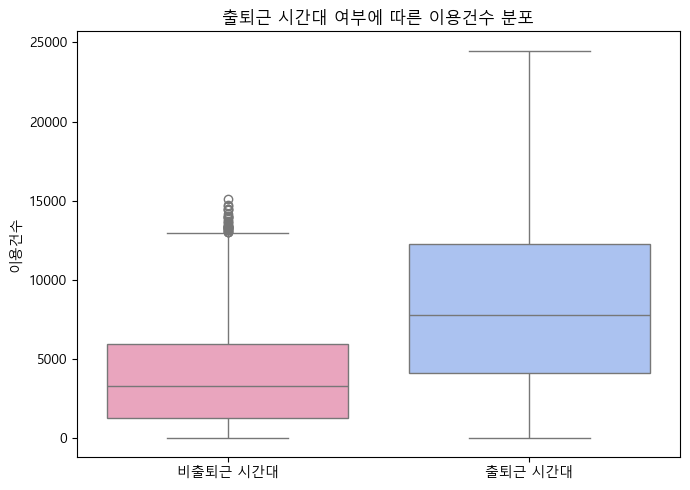

In [9]:
# 출퇴근 시간대 여부 vs 이용건수

df['commute_str'] = df['is_commute_time'].map({0: '비출퇴근 시간대', 1: '출퇴근 시간대'})

plt.figure(figsize=(7,5))
sns.boxplot(x='commute_str', y='이용건수', data=df,
            hue='commute_str', dodge=False,
            palette={'비출퇴근 시간대': '#f49abb', '출퇴근 시간대': '#9fbefc'})
plt.title('출퇴근 시간대 여부에 따른 이용건수 분포')
plt.ylabel('이용건수')
plt.xlabel('')
plt.tight_layout()
plt.show()

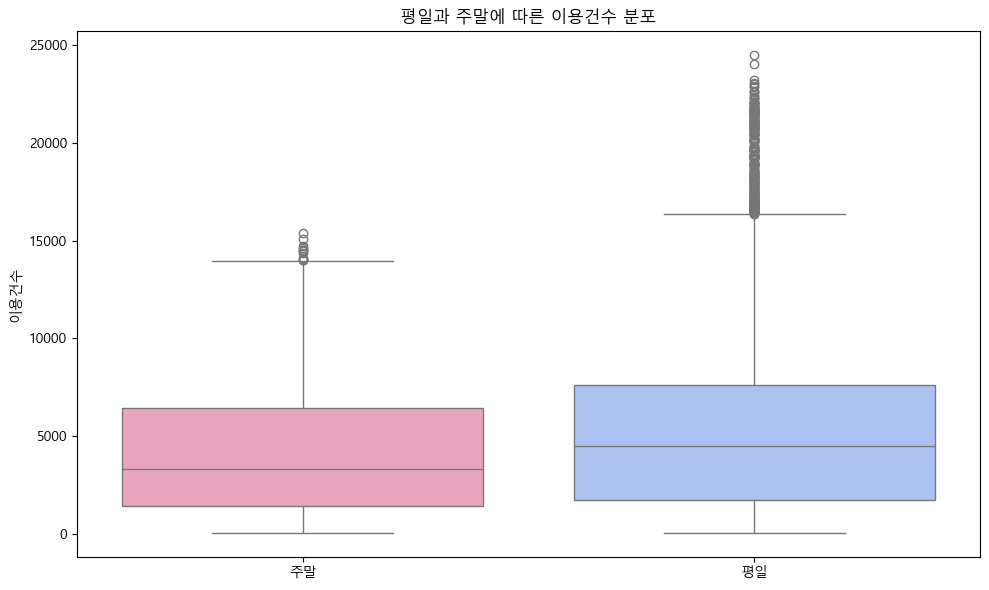

In [10]:
# 주말 여부 vs 이용건수

df['weekend_str'] = df['is_weekend'].map({0: '평일', 1: '주말'})

plt.figure(figsize=(10,6))
sns.boxplot(x='weekend_str', y='이용건수', data=df,
            hue='weekend_str', dodge=False,
            palette={'평일': '#9fbefc', '주말': '#f49abb'})
plt.title('평일과 주말에 따른 이용건수 분포')
plt.ylabel('이용건수')
plt.xlabel('')
plt.tight_layout()
plt.show()

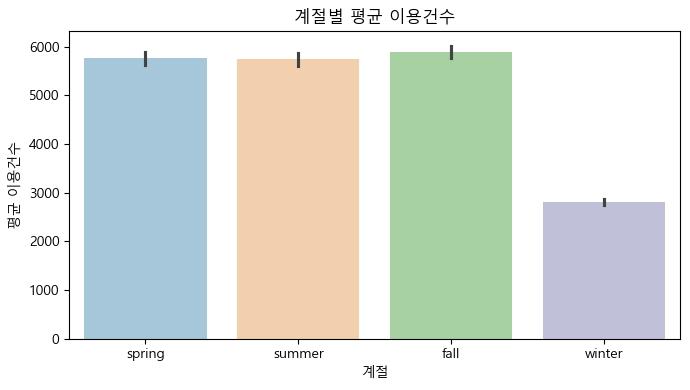

In [23]:
# 계절별 평균 이용건수

season_palette = {
    'spring': '#9ecae1',
    'summer': '#fdd0a2',
    'fall': '#a1d99b',
    'winter': '#bcbddc'
}

plt.figure(figsize=(7,4))
sns.barplot(x='season', y='이용건수', data=df, estimator=np.mean,
            order=['spring', 'summer', 'fall', 'winter'],
            hue='season', dodge=False,
            palette=season_palette)
plt.title('계절별 평균 이용건수')
plt.ylabel('평균 이용건수')
plt.xlabel('계절')
plt.tight_layout()
plt.show()


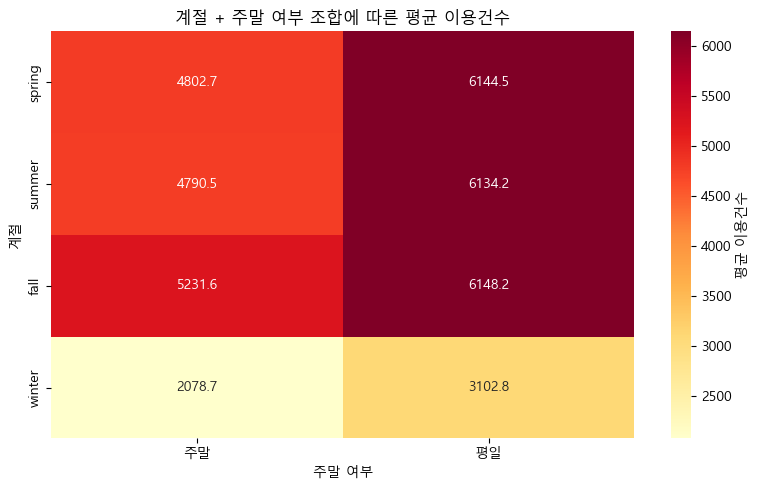

In [12]:
# 계절 + 주말 여부 조합 히트맵

pivot = df.pivot_table(index='season', columns='weekend_str', values='이용건수', aggfunc='mean')
pivot = pivot.reindex(index=['spring', 'summer', 'fall', 'winter'])

plt.figure(figsize=(8,5))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap='YlOrRd',
            cbar_kws={'label': '평균 이용건수'})
plt.title('계절 + 주말 여부 조합에 따른 평균 이용건수')
plt.ylabel('계절')
plt.xlabel('주말 여부')
plt.tight_layout()
plt.show()

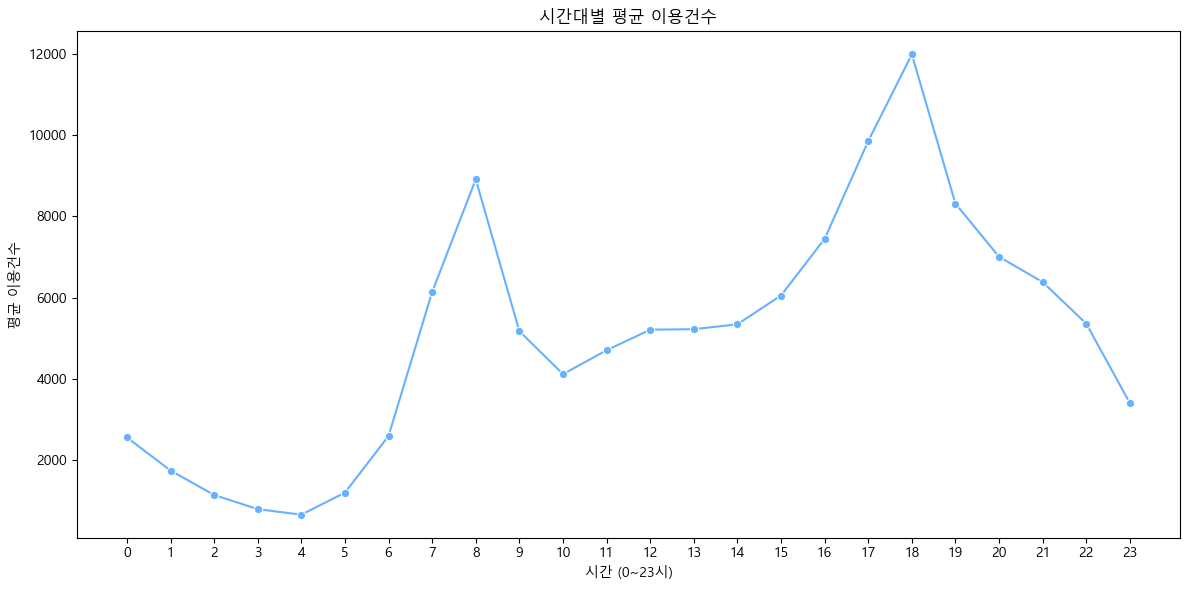

In [13]:
# 시간대별 평균 이용건수

plt.figure(figsize=(12,6))
sns.lineplot(x='hour', y='이용건수', data=df,
             estimator=np.mean, errorbar=None, marker='o', color='#66B2FF')
plt.title('시간대별 평균 이용건수')
plt.ylabel('평균 이용건수')
plt.xlabel('시간 (0~23시)')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

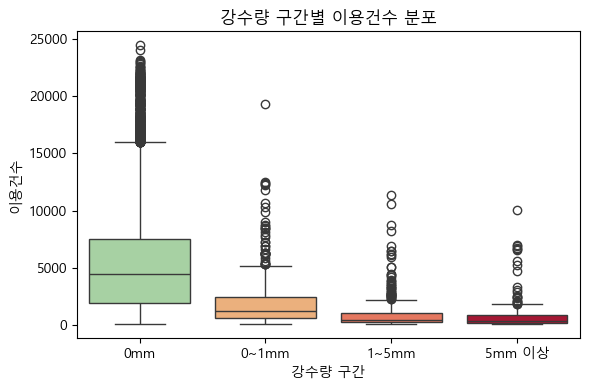

In [26]:
# 강수량 boxplot

df['rain_bin'] = df['강수량(mm)'].apply(lambda x: '0mm' if x == 0 else '0~1mm' if x <= 1 else '1~5mm' if x <= 5 else '5mm 이상')

plt.figure(figsize=(6,4))
sns.boxplot(
    x='rain_bin', y='이용건수', data=df,
    hue='rain_bin', dodge=False,
    order=['0mm', '0~1mm', '1~5mm', '5mm 이상'],
    palette={
        '0mm': '#a1d99b',
        '0~1mm': '#fdae6b',
        '1~5mm': '#fb6a4a',
        '5mm 이상': '#bd0026'
    }
)
plt.title('강수량 구간별 이용건수 분포')
plt.xlabel('강수량 구간')
plt.ylabel('이용건수')
plt.tight_layout()
plt.show()

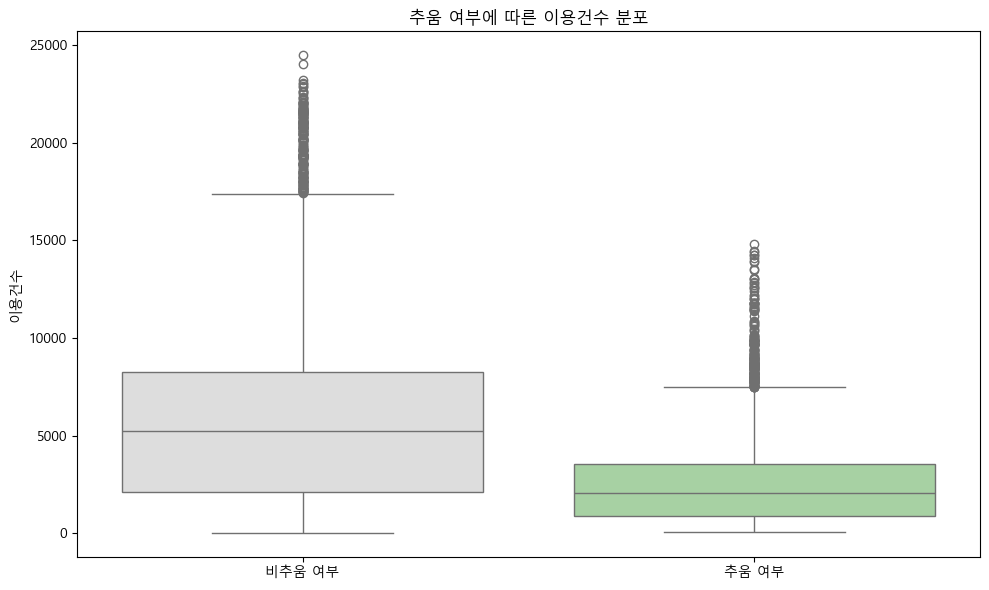

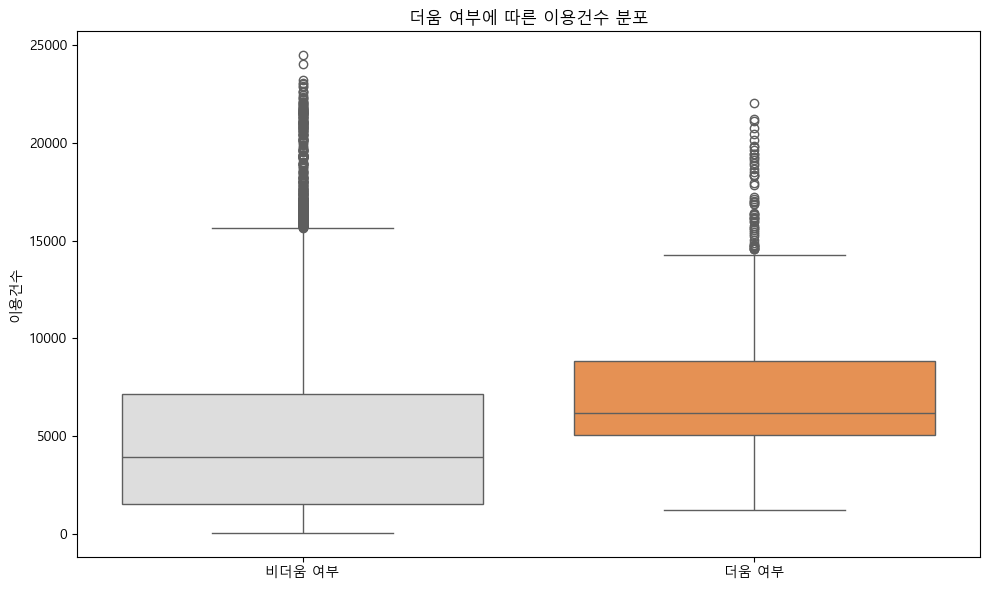

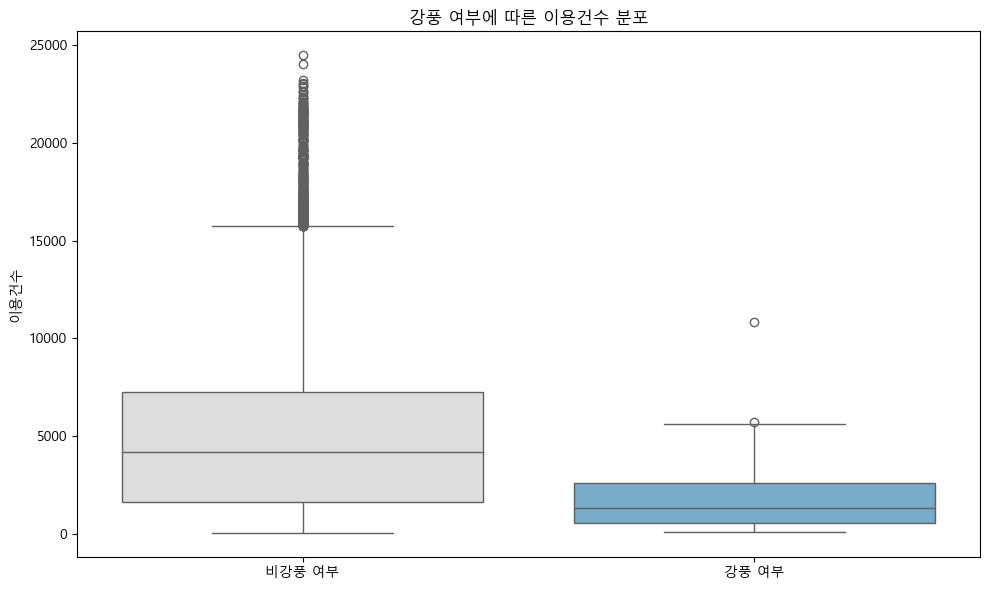

In [15]:
# 체감 추위/더위/강풍 여부별 boxplot

conditions = ['feels_cold', 'feels_hot', 'windy']
labels = ['추움 여부', '더움 여부', '강풍 여부']
colors = ['#a1d99b', '#fd8d3c', '#6baed6']

for cond, label, color in zip(conditions, labels, colors):
    df[f'{cond}_str'] = df[cond].map({0: f'비{label}', 1: label})
    
    plt.figure(figsize=(10,6))
    sns.boxplot(
        x=f'{cond}_str', y='이용건수', data=df,
        hue=f'{cond}_str', dodge=False,
        palette={f'비{label}': '#dddddd', label: color}
    )
    plt.title(f'{label}에 따른 이용건수 분포')
    plt.ylabel('이용건수')
    plt.xlabel('')
    plt.tight_layout()
    plt.show()

#### 모델링

In [16]:
feature_cols = ['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)',
                'hour', 'is_weekend', 'is_commute_time', 'is_rush_hour']

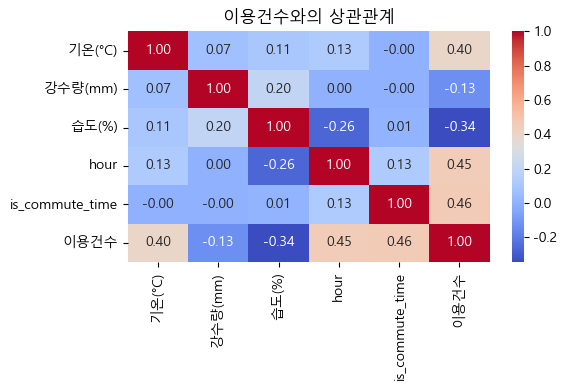

In [27]:
# ----------------
# 변수 선택
# ----------------

# 상관계수 시각화
plt.figure(figsize=(6,4))
corr = df[feature_cols + ['이용건수']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("이용건수와의 상관관계")
plt.tight_layout()
plt.show()

In [18]:
# is_commute_time과 is_rush_hour는 0.82로 매우 높음 → 다중공선성 우려 있음 → 따라서 제거

feature_cols = ['기온(°C)', '강수량(mm)', '습도(%)', 'hour', 'is_commute_time']

In [19]:
# ----------------
# 훈련세트, 테스트세트 분할
# ----------------

X = df[feature_cols]
y = df['이용건수']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# ----------------
# 모델 생성 및 훈련
# ----------------

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [21]:
# ----------------
# 예측 및 평가
# ----------------

# 예측 수행
y_pred = model.predict(X_test)

# 평가 지표 계산
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# 결과 출력
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")

MAE:  1949.19
RMSE: 2636.69
R²:   0.6092


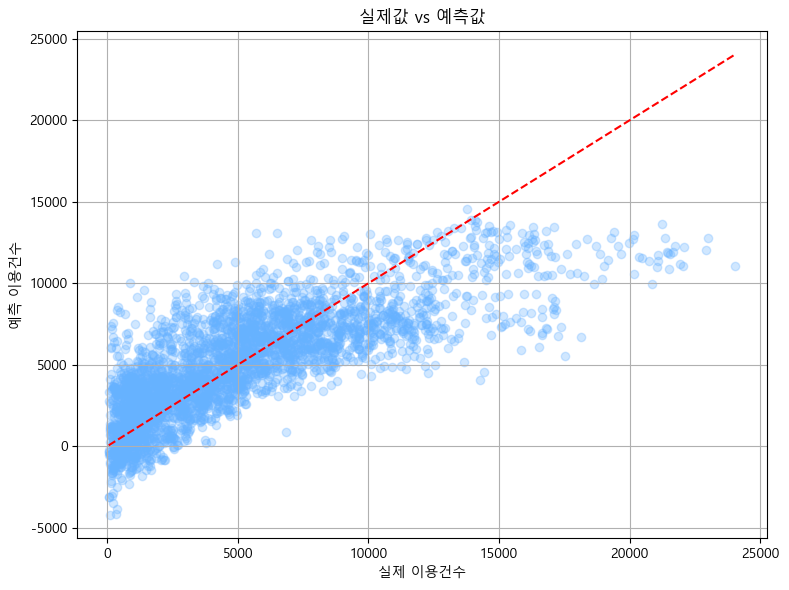

In [22]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.3, color='#66B2FF')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('실제 이용건수')
plt.ylabel('예측 이용건수')
plt.title('실제값 vs 예측값')
plt.grid(True)
plt.tight_layout()
plt.show()